**Tutorial 3 - Measuring a Spectral Line by Bayesian Parameter Estimation**

In this tutorial you will measure the strength and width of a spectral line 
using a Bayesian method.


1) Read in the data from the file tut_03_data.csv.  There are three 
columns: wavelength, flux and sigma.  Sigma is the known standard deviation 
of the flux in each pixel.  Plot the spectrum using matplotlib.pyplot.errorbar().

In [338]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pa
df = pa.read_csv('./tut_03_data.csv')
print(df)

    Unnamed: 0      flux  sigma  wavelength
0            0 -0.071036    0.1         0.0
1            1  0.078741    0.1         1.5
2            2 -0.055522    0.1         3.0
3            3  0.174301    0.1         4.5
4            4 -0.171562    0.1         6.0
..         ...       ...    ...         ...
62          62 -0.005968    0.1        93.0
63          63 -0.031031    0.1        94.5
64          64  0.254824    0.1        96.0
65          65 -0.086673    0.1        97.5
66          66  0.052072    0.1        99.0

[67 rows x 4 columns]


<ipython-input-339-3435c32a77a4>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "co" (-> color='c'). The keyword argument will take precedence.
  _1=plt.errorbar(df.wavelength, df.flux, yerr=df.sigma, elinewidth=0.5,  fmt='co', capsize=1, color='blue')


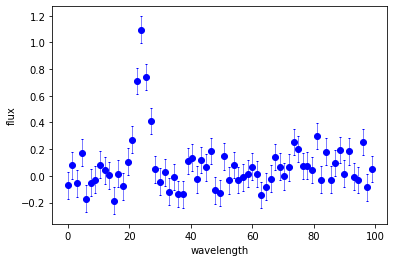

In [339]:
_1=plt.errorbar(df.wavelength, df.flux, yerr=df.sigma, elinewidth=0.5,  fmt='co', capsize=1, color='blue')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.show()

2) First we need to subtract off the continuum. We know that there is a line centred around $\lambda \simeq 23$.  Take the part of the spectrum with $\lambda > 45$ which should just be background.  Assume the noise is Gaussian and uncorrelated.   Using a uniform prior on the background.

In [340]:
import scipy.optimize as opt

## Separate out the background dominated region of the spectrum, 
##  wavelength > 45,  Make vectors of the flux, wavelength and 
## sigma for these pixels.

df_bk=df[df.wavelength>45]
print(df_bk)
np.shape(df_bk)

    Unnamed: 0      flux  sigma  wavelength
31          31  0.186415    0.1        46.5
32          32 -0.108002    0.1        48.0
33          33 -0.129238    0.1        49.5
34          34  0.145973    0.1        51.0
35          35 -0.034386    0.1        52.5
36          36  0.080228    0.1        54.0
37          37 -0.031855    0.1        55.5
38          38 -0.012030    0.1        57.0
39          39  0.016637    0.1        58.5
40          40  0.068624    0.1        60.0
41          41  0.014874    0.1        61.5
42          42 -0.144351    0.1        63.0
43          43 -0.081126    0.1        64.5
44          44 -0.020288    0.1        66.0
45          45  0.140241    0.1        67.5
46          46  0.069430    0.1        69.0
47          47 -0.004577    0.1        70.5
48          48  0.063326    0.1        72.0
49          49  0.253887    0.1        73.5
50          50  0.200819    0.1        75.0
51          51  0.073606    0.1        76.5
52          52  0.075423    0.1 

(36, 4)

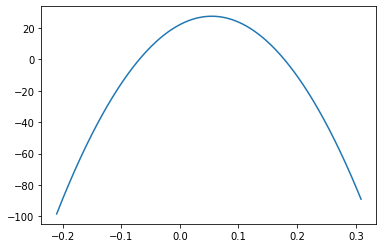

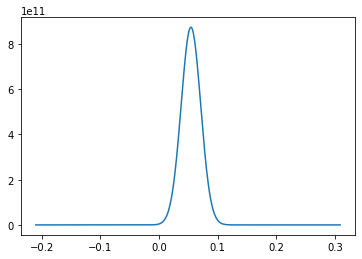

(array([265]),)


In [364]:
## Make a function that takes the background level b and 
## returns the log-likelihood calculated from the data 
## in the vectors above.  The pixels are statistically independent.
## You can use the df_bk_pixels dataframe made above inside the function
## you define.

data=np.array(df_bk.flux)
std=np.array(df_bk.sigma)

def loglike_gauss(b):
    likeli=(1/(np.sqrt(2*np.pi)*std[0]))*(np.exp(-(data[0]-b)**2/(2*std[0]**2)))
    for i in range(1,len(data)):
        d_likeli=(1/(np.sqrt(2*np.pi)*std[i]))*(np.exp(-(data[i]-b)**2/(2*std[i]**2)))
        likeli=likeli*d_likeli
    loglike=np.float64(np.log(likeli))
    return(loglike)

background=[]
background_exp=[]
for j in np.arange(-0.21,0.31,0.001):
    loglike_df_bk=loglike_gauss(j)
    background.append(loglike_df_bk)
    background_exp.append(np.exp(loglike_df_bk))
    
## Make an array of possible background values.  Call 
## it "background".
## To find the right range it is sometimes useful to 
## plot the log-likelihood over different ranges until 
## you find the maximum and you are sure the likelihood 
## is zero at both edges of the range.

_2=plt.plot(np.arange(-0.21,0.31,0.001),background)
plt.show()

background_co=np.array([np.arange(-0.21,0.31,0.001),background_exp], dtype=float)

_3=plt.plot(np.arange(-0.21,0.31,0.001),background_co[1])
plt.show()

print(np.where(background==np.max(background)))

In [365]:
print("max likelihood:", background_co[1][265])
print("a good value of background:", background_co[0][265])

max likelihood: 873824183411.2723
a good value of background: 0.05500000000000024


In [366]:
db = 0.001 ## resolution in background
background = np.arange(-0.1,0.15,db)

## Calculate the likelihood at each of these background values
## using the function you have made.

likelihood = np.zeros(len(background))
for i,b in enumerate(background) :
    likelihood[i]=np.exp(loglike_gauss(b))
print('Likelihood at maximum:', max(likelihood))

Likelihood at maximum: 873824183411.2723


check the integral: 1.0000000000000002


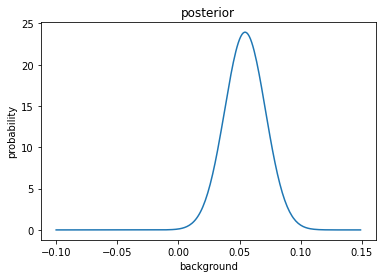

Posterior at edges of parameter space:  5.145873718776214e-18 2.5270200859345535e-06
Posterior at maximum:  23.92706518524241


In [367]:
## Normalize this numerically by summing the 
## likelihood array to get the posterior distribution 
## for the background.
## You should look at the plot and make sure that
## the sum is a good approximation of the integral, i.e. 
## the spacing in the parameter is small enough to make the 
## curve smooth and the range is large enough.

## plot posterior for background normalized numerically.
## Its integral should be 1.

posterior=likelihood/np.sum(likelihood)
fac=1/np.sum(posterior*db)

posterior=fac*posterior
print("check the integral:", np.sum(posterior*db))

_3=plt.plot(background, posterior)
plt.xlabel('background')
plt.ylabel('probability')
plt.title('posterior')
plt.show()

print('Posterior at edges of parameter space: ',posterior[0],posterior[-1])
print('Posterior at maximum: ', max(posterior))

In [381]:
## Find maximum of posterior and the variance numerically.  
## Use opt.fmin()
## The integrals can be made into sums.

log_like_2=lambda bb: -np.exp(loglike_gauss(bb))
likemax = opt.fmin(log_like_2, 0.05)[0]
#likemax = fac*likemax/np.sum(likelihood)

std_variance=np.std(posterior)

print('The maximum background value is :',likemax)
print('The standard deviation of the posterior  :',std_variance)

Optimization terminated successfully.
         Current function value: -874170096002.549927
         Iterations: 23
         Function evaluations: 46
The maximum background value is : 0.05453108787536621
The standard deviation of the posterior  : 7.190462491501138


3) Now lets fit the line.  Assume the line has the profile

$ f(\lambda) = A \exp\left[- \left( \frac{(\lambda - \lambda_o)}{\Delta\lambda }\right)^2 \right] $

We want to find the parameters $A$, $\lambda_o$, $\Delta\lambda$ and the background.  

In [265]:
import sys

f = df['flux']
lam = df['wavelength']
s = df['sigma']

## Write a function for the line profile that takes 
## the wavelength, A, center of line, lo, and the width 
## of the line dl.
class jc_fit():

    std=np.array([])
    def __init__(self,std, la=np.array([]), flux_o=np.array([]), Type=" "):
        self.lam=la
        self.std=std
        self.flux_o=flux_o
        self.Type=Type
        
    def line_profile(self, p=np.array([])):
        self.p=p
        flux_s=self.p[0]*np.exp(-((self.lam-self.p[1])/self.p[2])**2)
        self.flux_s=flux_s
        return(self.flux_s)

    ## Write a function that takes the parameters 
    ## A,lo,dl,b and returns the log-likelihood for 
    ## the data.  The function should have the signature 
    ## def loglike(p): where p[0]=A, p[1]=lo, p[2]=dl and p[3]=b
    ## You should use the original dataframe for the data with 
    ## the full range of wavelength.

    def loglike(self, p=np.array([])):
        self.p=p
        if(self.p[2] <= 0):
            return sys.float_info.max
        if self.Type=="Gauss":
            like= 0.5*np.sum(((self.flux_o-self.p[3]-jc_fit.line_profile(self,p))/self.std)**2)
        return like
    
    
## Find the maximum likelihood values for the parameters using 
## the whole data set.  Use the library function 
## scipy.optimize.minimize() to do this. Note that what  
## this function returns is a structure with more than just the solution.
## Read the documentation for this function before starting.  You will
## need to make a guess to start the minimization.  Make these 
## guesses from the plot of the data.  

                                                                  
par=np.array([1, 25, 5, 0])
p_zero=np.array([1,1,1,1])
fit=jc_fit(std=np.array(s), la=np.array(lam), flux_o=f, Type="Gauss")
maxlikelihood = opt.minimize(fit.loglike, par)                                                                  
print('maximum likelihood solution : ', maxlikelihood.x)

maximum likelihood solution :  [ 1.02866768 24.11716855  2.61398136  0.0286165 ]


<ipython-input-228-3c0635041c82>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "co" (-> color='c'). The keyword argument will take precedence.
  plt.errorbar(df.wavelength, df.flux, yerr=df.sigma, elinewidth=0.5,  fmt='co', capsize=1, color='blue')
<ipython-input-228-3c0635041c82>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "co" (-> color='c'). The keyword argument will take precedence.
  plt.errorbar(df.wavelength, df.flux, yerr=df.sigma, elinewidth=0.5,  fmt='co', capsize=1, color='blue')


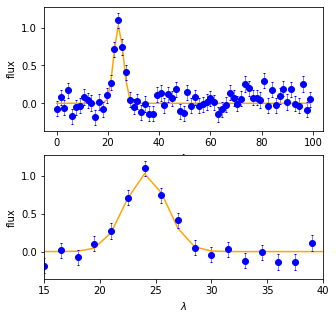

In [228]:
## 4) Plot the best fit model over the plot of the data made in 
## part 1).  Use your line_profile() function.

x = maxlikelihood.x
y = fit.line_profile(x)

plt.figure(figsize=(5,5))
_4=plt.subplot(211)
_4.plot(lam, y, c='orange')
plt.errorbar(df.wavelength, df.flux, yerr=df.sigma, elinewidth=0.5,  fmt='co', capsize=1, color='blue')
plt.xlabel(r'$\lambda$')
plt.ylabel('flux')

_5=plt.subplot(212)
_5.plot(lam, y, c='orange')
plt.errorbar(df.wavelength, df.flux, yerr=df.sigma, elinewidth=0.5,  fmt='co', capsize=1, color='blue')
plt.xlim(15,40)
plt.xlabel(r'$\lambda$')
plt.ylabel('flux')

plt.show()

5) Set all the parameters to their maximum likelihood values except the line strength $A$.  Make a plot of the **conditional posterior** for $A$ near its maximum likelihood value with uniform and Jaffreys priors on $A$.

0.9999999999999999


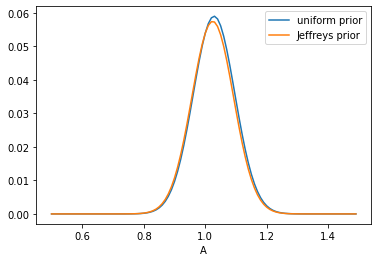

Does the choice of prior change the result significantly? 
Jeffery prior: [1.02]
Opt.minimize estimation: 1.0286676786180036
No
----------
Jeffery posterior at edges of parameter space:  6.549742549888434e-15 3.188511153187982e-12
Posteriors at edges of parameter space:  3.274871274944217e-15 4.750881618250096e-12


In [276]:

Aarray = np.array(np.arange(0.5,1.5,0.01))

posterior = np.empty(len(Aarray))
for i,A in enumerate(Aarray):
    posterior[i]=np.exp(-fit.loglike(p=[A,x[1],x[2],x[3]]))

## normalize the posterior
posterior= posterior/np.sum(posterior)
print(np.sum(posterior))
      
##Jeffrey priors
jeffery_p=posterior/Aarray

_6=plt.plot(Aarray,posterior,label='uniform prior')
_7=plt.plot(Aarray,jeffery_p,label='Jeffreys prior')

plt.legend()
plt.xlabel('A')
plt.show()

print("Does the choice of prior change the result significantly? ")
print("Jeffery prior:", Aarray[np.where(jeffery_p==max(jeffery_p),True, False)])
print("Opt.minimize estimation:", maxlikelihood.x[0])
print("No")
print('----------')
print('Jeffery posterior at edges of parameter space: ',jeffery_p[0],jeffery_p[-1])
print('Posteriors at edges of parameter space: ', posterior[0], posterior[-1])

6) Make a 2D map of the conditional posterior as a function of $A$ and $\Delta \lambda$ at the maximum likelihood values of the other parameters.  Do this by making a grid of $A$ and $\Delta \lambda$ values and using matplotlib.pyplot.contour().  Put the proper labels on the axes.

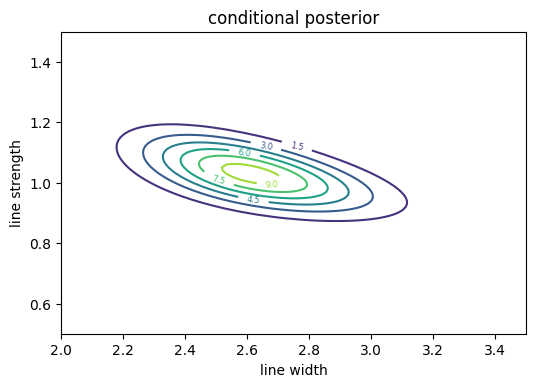

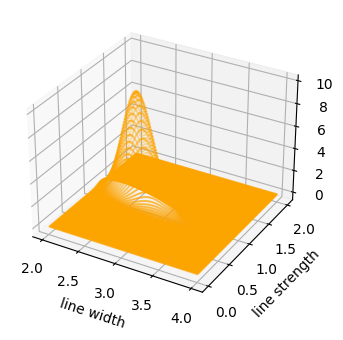

In [230]:
ddl = 0.01
dA = 0.01
dlarray = np.arange(2.01,4.01,0.01)
Aarray = np.arange(0.01,2.01,0.01)

post = np.zeros(shape=(len(Aarray),len(dlarray)))
for i,A in enumerate(Aarray):
    for j,dl in enumerate(dlarray):
        post[i][j]=np.exp(-fit.loglike(p=np.array([A,x[1],dl,x[3]])))
        
#normalization
post=post/(np.sum(post)*ddl*dA)   

## this is very useful for making 2D plots. X and Y are 2D arrays.
plt.figure(dpi=100)
X, Y = np.meshgrid(dlarray, Aarray)
_8=plt.contour(X,Y,post)
plt.clabel(_8, inline=True, fontsize=6)
plt.xlim(2,3.5)
plt.ylim(0.5,1.5)

plt.xlabel('line width')
plt.ylabel('line strength')
plt.title("conditional posterior")

plt.show()

plt.figure(dpi=100)
_3d=plt.axes(projection="3d",label='conditional posterior')
_3d.scatter3D(X, Y, post, s=0.5, c='orange', alpha=0.3)

plt.xlabel('line width')
plt.ylabel("line strength")
plt.show()

7) Write a function that takes values for $A$ and $\Delta \lambda$ and returns the 
posterior **marginalized** over $\lambda_o$.  Use scipy.integrate.quad() to do the 
integration.  You will need to make a new "posterior" function with the correct 
order of input parameters to use this function.  Use the maximum likelihood value for the background from part 2).  You might want to reduce the resolution of the grid to reduce the run time.

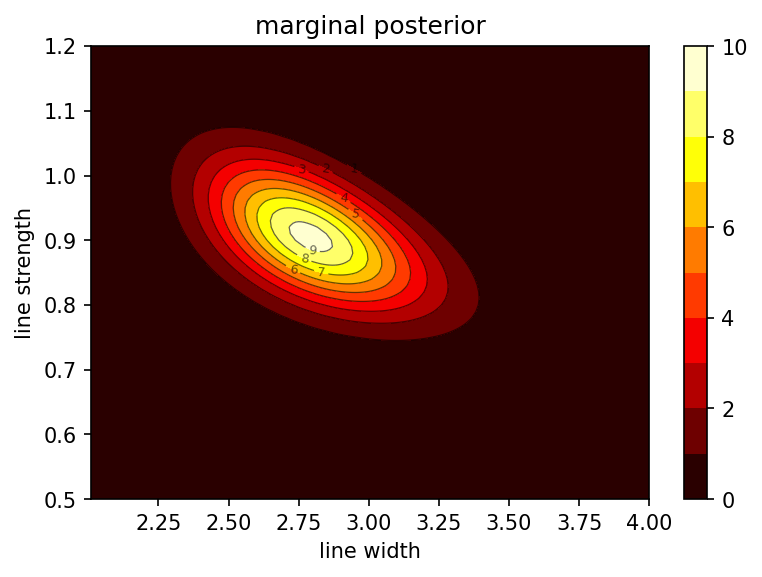

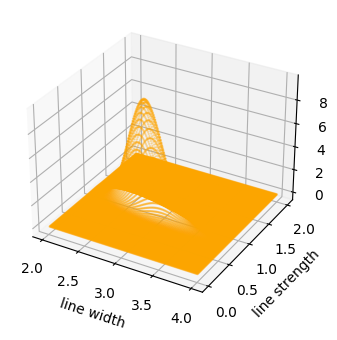

In [231]:
from scipy.integrate import quad

dlarray = np.arange(2.01,4.01,0.01)
Aarray = np.arange(0.01,2.01,0.01)
mar_p=np.zeros(shape=(len(Aarray), len(dlarray)))

fit=jc_fit(std=np.array(s), la=np.array(lam), flux_o=np.array(f), Type='Gauss')
back=0.055

# this reorders the parameters
def posterior(lo,A,dl,b):
    return np.exp(-fit.loglike(p=np.array([A, lo, dl, b])))  
        
def marginal_posterior(A,dl,b):
    ## use quad to integrate over lo only using the arg option
    mar_post=quad(posterior, 0, 100, args=(A,dl,b))[0]
    return mar_post

for i,A in enumerate(Aarray):
    for j,dl in enumerate(dlarray):
        mar_p[i][j]=marginal_posterior(A, dl, back)

#Normalization
mar_p=mar_p/(np.sum(mar_p)*ddl*dA)
        
plt.figure(dpi=150)
X, Y = np.meshgrid (dlarray, Aarray)
_9 = plt.contour(X,Y,mar_p, 10, colors='black', linewidths=0.6, alpha=0.6)
plt.clabel(_9, inline=True, fontsize=6)
_9f=plt.contourf(X,Y,mar_p, 10, cmap=plt.cm.hot)
plt.colorbar(mappable=_9f)

plt.ylim(0.5, 1.20)
plt.xlabel('line width')
plt.ylabel('line strength')
plt.title("marginal posterior")

plt.show()

plt.figure(dpi=100)
_3d=plt.axes(projection="3d",label='conditional posterior')
_3d.scatter3D(X, Y, mar_p, s=0.5, c='orange', alpha=0.3)

plt.xlabel('line width')
plt.ylabel("line strength")
plt.show()

8) Sum the 2D array from 7) to find the 1D marginalized posteriors for both 
$\Delta\lambda$ and $A$.  This is a numerical marginalization which can be done by simply summing along each of the axes.  The sum approximates an integral over the parameter.

Plot both marginal distributions.  If these are not smooth, you haven't used enough points in parameter space.

In [232]:
#########################################
#  This function finds the level for a contour that contains 
#  a fixed fraction of the total sum of pixels (or voxels).
#  Understand it. Run this box so that it is defined
#########################################
def find_level(posterior,fraction) :
    tot = np.sum(posterior)
    max = np.max(posterior)
    min = np.min(posterior)

    ## initialize level to halfway between max and min
    level = 0.5*(max + min) 
    ## initialize fraction for this level
    frac = np.sum( posterior[ posterior >= level ]  )/tot
    ## initialize resolution = +/- smallest pixel as fraction of total
    res = np.min( posterior[ posterior >= level ]  )/tot

    ## iterate until frac is within res of the input fraction
    while( abs(frac - fraction) > res  ) :
        
        ## update max or min
        if( frac > fraction) :
            min = level
        else :
            max = level
        
        ## update level by bisecting 
        level = 0.5*(max + min)
        
        ## update frac and res    
        frac = np.sum( posterior[ posterior >= level ] )/tot
        res = np.min( posterior[ posterior >= level ]  )/tot

    ## output the level and its actual fraction
    return level,frac

###

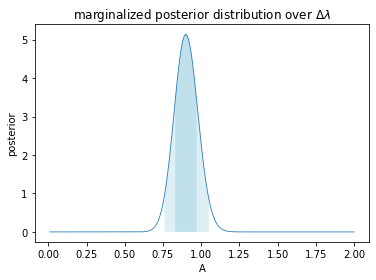

1.0
0.9999999999999999


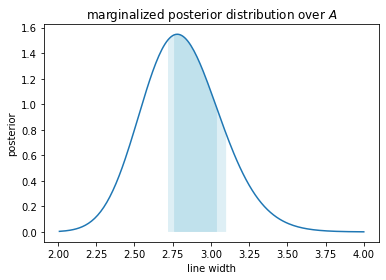

In [233]:
#####
sum_A=np.sum(mar_p, axis=1)
sum_dl=np.sum(mar_p, axis=0)

#normalization
sum_A=sum_A/(np.sum(sum_A)*dA)
sum_dl=sum_dl/(np.sum(sum_dl)*ddl)

_68_A=find_level(sum_A, 0.68)[0]
_68_dl=find_level(sum_dl, 0.68)[0]
_95_A=find_level(sum_A, 0.95)[0]
_95_dl=find_level(sum_dl, 0.95)[0]
p=np.array([[_68_A, _68_dl],[_95_A, _95_dl]])

_10=plt.plot(Aarray, sum_A, linewidth=0.8)
plt.xlabel('A')
plt.ylabel('posterior')

plt.fill_between(Aarray,sum_A, 0, where=(sum_A>p[0][0]), facecolor='lightblue', alpha=0.6)
plt.fill_between(Aarray,sum_A, 0, where=(sum_A>p[1][0]), facecolor='lightblue', alpha=0.4)

plt.title(r'marginalized posterior distribution over $\Delta\lambda$')
plt.show()

print(np.sum(sum_A*dA))

_11=plt.plot(dlarray, sum_dl)
plt.xlabel('line width')
plt.ylabel('posterior')

plt.fill_between(dlarray,sum_dl, 0, where=(sum_A>p[0][1]), facecolor='lightblue', alpha=0.6)
plt.fill_between(dlarray,sum_dl, 0, where=(sum_A>p[1][1]), facecolor='lightblue', alpha=0.4)

print(np.sum(sum_dl*ddl))

plt.title(r'marginalized posterior distribution over $A$')
plt.show()


9) Find the mean and variance for $\Delta\lambda$ and the $A$ using the map of the marginalized posterior found above, the X and Y arrays from above, and the numpy.sum() function.  Each of these will be marginalized over all other variables except the background.  Do the integrals by simply summing in the appropriate dimensions.

In [234]:
#Checking variance and mean with 3 methods

#np.sum
dat=np.zeros(shape=(2,2))

A_av=np.average(sum_A)
A_var=np.var(sum_A)

dl_av=np.average(sum_dl)
dl_var=np.var(sum_dl)

dat[0][0]=A_av
dat[0][1]=A_var
dat[1][0]=dl_av
dat[1][1]=dl_var

print(dat)
print('----------')

#X and Y arrays


[[0.5        1.56659694]
 [0.5        0.295259  ]]
----------


In [235]:
#########################################
#  This function finds the level for a contour that contains 
#  a fixed fraction of the total sum of pixels (or voxels).
#  Understand it. Run this box so that it is defined
#########################################
def find_level(posterior,fraction) :
    tot = np.sum(posterior)
    max = np.max(posterior)
    min = np.min(posterior)

    ## initialize level to halfway between max and min
    level = 0.5*(max + min) 
    ## initialize fraction for this level
    frac = np.sum( posterior[ posterior >= level ]  )/tot
    ## initialize resolution = +/- smallest pixel as fraction of total
    res = np.min( posterior[ posterior >= level ]  )/tot

    ## iterate until frac is within res of the input fraction
    while( abs(frac - fraction) > res  ) :
        
        ## update max or min
        if( frac > fraction) :
            min = level
        else :
            max = level
        
        ## update level by bisecting 
        level = 0.5*(max + min)
        
        ## update frac and res    
        frac = np.sum( posterior[ posterior >= level ] )/tot
        res = np.min( posterior[ posterior >= level ]  )/tot

    ## output the level and its actual fraction
    return level,frac

###

10) Using the function above, find the 68% and 95% confidence regions for $A$ and $\Delta\lambda$ and make a 2D contour plot of these levels.

In [281]:
_68_A=find_level(sum_A, 0.68)[0]
_68_dl=find_level(sum_dl, 0.68)[0]
_95_A=find_level(sum_A, 0.95)[0]
_95_dl=find_level(sum_dl, 0.95)[0]
p=np.array([[_68_A, _68_dl],[_95_A, _95_dl]])

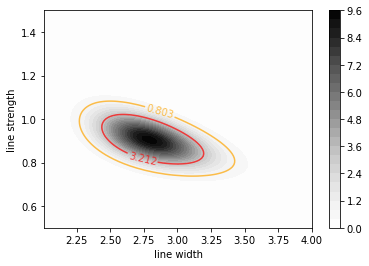

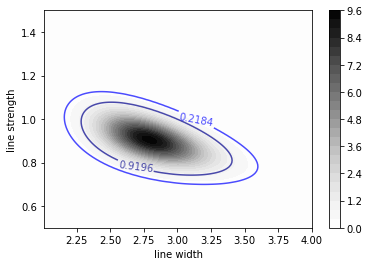

In [388]:
#
dlarray = np.arange(2.01,4.01,0.01)
Aarray = np.arange(0.01,2.01,0.01)
X,Y=np.meshgrid(dlarray, Aarray)
cc=plt.contourf(X,Y,mar_p, 30, cmap='Greys')
_12=plt.contour(X,Y,mar_p,[_95_A, _68_A], colors=['orange','red'], alpha=0.7)
plt.ylim(0.5,1.5)
plt.xlabel('line width')
plt.ylabel("line strength")
plt.clabel(_12,)
plt.colorbar(mappable=cc)
plt.show()

_13=plt.contour(X,Y,mar_p,[_95_dl, _68_dl], colors=['blue','darkblue'], alpha=0.7,)
cc=plt.contourf(X,Y,mar_p, 30, cmap='Greys')
plt.clabel(_13, inline=True)
plt.colorbar(mappable=cc)
plt.ylim(0.5,1.5)
plt.xlabel('line width')
plt.ylabel("line strength")

plt.show()